In [108]:
import numpy as np
import math
import matplotlib.pyplot as plot
from keras import datasets
from keras.utils import to_categorical

# Data Importing

In [2]:
(Xtrain,Ytrain),(xtest,ytest)= datasets.mnist.load_data()
Xtrain=Xtrain.reshape(60000,784)/255
xtest=xtest.reshape(10000,784)/255

# Adding 48 to labels and converting to 6 bit binary format

In [4]:
Ytrain = Ytrain + 48
ytest = ytest + 48
def label_vector_format(array,no_of_bits):
    new_vectors = []
    for value in array:
        new_vectors.append(np.array(list(np.binary_repr(value).zfill(no_of_bits))).astype(np.int8))
    return new_vectors

Ytrain = label_vector_format(Ytrain,6)
ytest = label_vector_format(ytest,6)

# Get parameters such as weights and bias vector for each layer

In [5]:
input_nodes = 784
no_of_layers = 7
no_of_nodes = 128

def get_layer_parameters(input_nodes,no_of_layers,no_of_nodes):
    layer_weights = [np.random.randn(no_of_nodes, input_nodes)]
    for i in range(no_of_layers -1):
        layer_weights.append(np.random.randn(no_of_nodes,no_of_nodes))
    layer_weights.append(np.random.randn(6,no_of_nodes))
    bias_vector =[]
    
    for i in range(len(layer_weights)):
        print(layer_weights[i].shape)
        bias_vector.append(np.zeros(layer_weights[i].shape))
    
    return dict(layer_weights=layer_weights,bias_vector=bias_vector)
get_layer_parameters(input_nodes,no_of_layers,no_of_nodes)

(128, 784)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(6, 128)


{'layer_weights': [array([[-0.53132879, -0.12318682,  1.83988367, ...,  0.50584562,
          -1.75690842,  0.3336723 ],
         [ 0.19000702,  1.47728857,  0.30979685, ..., -0.34352606,
          -1.14604788,  1.40146612],
         [-0.40683668,  0.10431168, -1.42656312, ...,  0.1376302 ,
           2.26665964,  0.77141111],
         ...,
         [-0.60459524, -0.72648204,  1.03320557, ..., -0.55894293,
          -0.22626563, -0.70247704],
         [ 0.02279421, -0.22625094,  1.43142391, ..., -0.02524062,
          -0.19782808, -0.14197867],
         [-0.57188893, -1.75256684,  0.09818278, ...,  0.59097194,
          -0.26633202,  1.23327201]]),
  array([[ 0.07246719,  0.45407592, -1.07219772, ..., -0.20795663,
           0.22948227,  0.86661795],
         [ 0.37200783,  0.65715734,  0.90266125, ...,  0.79618001,
          -0.50888562, -0.71241407],
         [-0.48612425,  2.46939569, -0.05586738, ...,  0.5742223 ,
           1.38561887, -1.15108736],
         ...,
         [ 1.9949

# Functions used to train  MLP model

In [229]:
def sigmoid(value):
    return 1.0/(1.0 + np.exp(-1.0 * value))
def dot_product(value1,value2):
    return np.dot(value1,value2)    

def forward_propogation_with_dropout(X,parameters,drop_value=0.5):
    
    active_layer = sigmoid(dot_product(X,parameters['layer_weights'][0].T))                              
    activeLayers_output = [active_layer]
    drop_outputs = []
    
    drop_layers = [2,4]    
    
    for i in range(1,len(parameters['layer_weights'])):
        active_layer = sigmoid(dot_product(activeLayers_output[i-1],parameters['layer_weights'][i].T))
        if i in drop_layers:
            drop = np.random.randn(active_layer.shape[0],active_layer.shape[1])     
            drop = (drop > drop_value)                             
            active_layer = active_layer * drop                                      
            drop_outputs.append(drop)
        activeLayers_output.append(active_layer)
    return activeLayers_output,drop_outputs


def forward_propogation(X,parameters):
    activeLayers_output = [sigmoid(dot_product(X,parameters['layer_weights'][0].T))]
    
    for i in range(1,len(parameters['layer_weights'])):
        activeLayers_output.append(sigmoid(dot_product(activeLayers_output[i-1],parameters['layer_weights'][i].T)))
    return activeLayers_output
def back_propagate(X,Y,parameters,learning_rate,active_layers):
    
    new_layer_weights = parameters['layer_weights']
    new_bias_vectors = parameters['bias_vector']
    
    do = active_layers[-1]*(1-active_layers[-1])*(Y-active_layers[-1])
    new_bias_vectors[-1] = 0.9*new_bias_vectors[-1]+ dot_product(do.T,active_layers[-2])
    new_layer_weights[-1] = new_layer_weights[-1]+learning_rate*new_bias_vectors[-1]
    
    for i in reversed(range(1,len(new_layer_weights)-1)):
        
        do = active_layers[i]*(1-active_layers[i])*dot_product(do,new_layer_weights[i+1])
        new_bias_vectors[i] = 0.9*new_bias_vectors[i]+ dot_product(do.T,active_layers[i-1])
        new_layer_weights[i] = new_layer_weights[i]+learning_rate*new_bias_vectors[i]
        
    do = active_layers[0]*(1-active_layers[0])*dot_product(do,new_layer_weights[1])
    new_bias_vectors[0] = 0.9*new_bias_vectors[0]+ dot_product(do.T,X)
    new_layer_weights[0] = new_layer_weights[0]+learning_rate*new_bias_vectors[0]
    
    return dict(layer_weights=new_layer_weights,bias_vector=new_bias_vectors)

def back_propagate_with_regularization(X,Y,parameters,learning_rate,active_layers,lambda_value=0.5):
    
    new_layer_weights = parameters['layer_weights']
    new_bias_vectors = parameters['bias_vector']
    m = X.shape[0]
    
    
    do = active_layers[-1]*(1-active_layers[-1])*(Y-active_layers[-1])
    new_bias_vectors[-1] = 0.9*new_bias_vectors[-1]+ dot_product(do.T,active_layers[-2]) + (lambda_value/m)*new_layer_weights[-1]
    new_layer_weights[-1] = new_layer_weights[-1]+learning_rate*new_bias_vectors[-1]
    
    for i in reversed(range(1,len(new_layer_weights)-1)):
        
        do = active_layers[i]*(1-active_layers[i])*dot_product(do,new_layer_weights[i+1])
        new_bias_vectors[i] = 0.9*new_bias_vectors[i]+ dot_product(do.T,active_layers[i-1]) + (lambda_value/m)*new_layer_weights[i]
        new_layer_weights[i] = new_layer_weights[i]+learning_rate*new_bias_vectors[i]
        
    do = active_layers[0]*(1-active_layers[0])*dot_product(do,new_layer_weights[1])
    new_bias_vectors[0] = 0.9*new_bias_vectors[0]+ dot_product(do.T,X) + (lambda_value/m)*new_layer_weights[0]
    new_layer_weights[0] = new_layer_weights[0]+learning_rate*new_bias_vectors[0]
    
    return dict(layer_weights=new_layer_weights,bias_vector=new_bias_vectors)

def back_propagate_with_dropout(X,Y,parameters,learning_rate,active_layers,dropout_layers,drop_value=0.5):
    
    new_layer_weights = parameters['layer_weights']
    new_bias_vectors = parameters['bias_vector']    
    drop_layers = [2,4]
    do = active_layers[-1]*(1-active_layers[-1])*(Y-active_layers[-1])
    new_bias_vectors[-1] = 0.9*new_bias_vectors[-1]+ dot_product(do.T,active_layers[-2])
    new_layer_weights[-1] = new_layer_weights[-1]+learning_rate*new_bias_vectors[-1]
    
    for i in reversed(range(1,len(new_layer_weights)-1)):
        
        do = active_layers[i]*(1-active_layers[i])*dot_product(do,new_layer_weights[i+1])
        new_bias_vectors[i] = 0.9*new_bias_vectors[i]+ dot_product(do.T,active_layers[i-1])
        new_layer_weights[i] = new_layer_weights[i]+learning_rate*new_bias_vectors[i]
        if i in drop_layers:
            active_layers[i-1] *= drop_layers.pop(0)
        
        
    do = active_layers[0]*(1-active_layers[0])*dot_product(do,new_layer_weights[1])
    new_bias_vectors[0] = 0.9*new_bias_vectors[0]+ dot_product(do.T,X)
    new_layer_weights[0] = new_layer_weights[0]+learning_rate*new_bias_vectors[0]
    
    return dict(layer_weights=new_layer_weights,bias_vector=new_bias_vectors)

def add_noise(X,mean=0,std=0.01**0.5,salt_pepper = 0.2,amount=0.004,noise_type='gaussian'):
    X =X.reshape(X.shape[0],28,28,1)/255
    print(X.shape)
    images,channels,rows,columns = X.shape
    
    if noise_type =='gaussian': 
        noise = np.random.normal(mean, std/255., 
                                     (images, channels, rows, columns))
        noise_X = X + noise
        clip_x = np.clip(noise_X, 0., 1.)
    
        return clip_x.reshape(X.shape[0],784)
    
    elif noise_type == 'speckle':
        print('a')
        noise_images=[]
        count =0
        for image in X:
            count+=1
            noise = np.random.randn(channels, rows, columns)
            noise_X = image + image * noise
            noise_images.append(noise_X)
        return np.array(noise_images).reshape(X.shape[0],784)
    

# For 5,7 layers with Regularization

In [262]:
def mlp_model(XTrain,YTrain,Xtest,Ytest,layers,learning_rate=0.00005,iterations = 300):
    
    train_errors = []
    test_errors = []
    final_predicted_values=[]
    parameters = get_layer_parameters(784,layers,128)
    for i in range(iterations):
        active_layers,drop_outputs = forward_propogation_with_dropout(XTrain,parameters,0.0)
        train_errors.append(np.sum(np.abs(YTrain - active_layers[-1]))/XTrain.shape[0])
        print("Train error " + str(np.sum(np.abs(YTrain - active_layers[-1]))/XTrain.shape[0]))
        parameters = back_propagate_with_dropout(XTrain,YTrain,parameters,learning_rate,active_layers,drop_outputs,0.0)
        parameters = back_propagate_with_regularization(XTrain,YTrain,parameters,learning_rate,active_layers,6.5)
        test_active_layers,test_drop_outputs = forward_propogation_with_dropout(Xtest,parameters,0.0)
        test_errors.append(np.sum(np.abs(Ytest - test_active_layers[-1]))/Xtest.shape[0])
        print("Test error " + str(np.sum(np.abs(Ytest - test_active_layers[-1]))/Xtest.shape[0]))
        final_predicted_values = test_active_layers[-1]
    return train_errors,test_errors,final_predicted_values
    

In [263]:
train_errors_reg_5,test_error_reg_5,final_predicted_values_reg_5=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],5)
train_errors_reg_7,test_error_reg_7,final_predicted_values_reg_7=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],5)

(128, 784)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(6, 128)
Train error 3.562747383161157
Test error 3.577552460555111
Train error 3.56716267300182
Test error 3.598393426739108
Train error 3.6126118511147416
Test error 3.663965202593344
Train error 3.6005908799920485
Test error 3.546667170084147
Train error 3.595798930487704
Test error 3.547032039353711
Train error 3.53138289228483
Test error 3.410429311236154
Train error 3.4900431826137646
Test error 3.431477175803493
Train error 3.3944642116738923
Test error 3.3604931498587587
Train error 3.3338018319406255
Test error 3.1837217755673635
Train error 3.2315253981471908
Test error 3.1066086031002174
Train error 3.1116807391926535
Test error 3.027520227228846
Train error 3.017685959335119
Test error 2.8903488987990213
Train error 2.908222549441565
Test error 2.769907200028346
Train error 2.784181859881731
Test error 2.6887200603678547
Train error 2.693464788481434
Test error 2.5504519627629896
Train error 2.552576612855049
Test error

Test error 1.6338762816910504
Train error 1.6867961561091434
Test error 1.6156006672224352
Train error 1.6689901785500767
Test error 1.646946183987726
Train error 1.6656563588296869
Test error 1.6172255449164652
Train error 1.689155164137329
Test error 1.6218318845431248
Train error 1.6717966787178908
Test error 1.6136532769807692
Train error 1.6977746148486348
Test error 1.6093574381466516
Train error 1.6835119286731655
Test error 1.5686467018180519
Train error 1.6733831287362095
Test error 1.635106917968768
Train error 1.6638017909587306
Test error 1.60926263909479
Train error 1.6776823271424557
Test error 1.6047383970253595
Train error 1.6622261602224306
Test error 1.5985807582418017
Train error 1.6595721548469067
Test error 1.5829695347272252
Train error 1.666663561437276
Test error 1.6203130755806479
Train error 1.6729166238271422
Test error 1.6579777759333099
Train error 1.6478545911061937
Test error 1.5803968636049348
Train error 1.6736227489030413
Test error 1.6487147209926827


Train error 1.5295058438613047
Test error 1.5602286439442472
Train error 1.528441185288198
Test error 1.5121720189725993
Train error 1.5414286799868284
Test error 1.5475212029640204
Train error 1.5206643827603399
Test error 1.5405972927354423
Train error 1.5572311819639586
Test error 1.506770608466183
Train error 1.5458424695152388
Test error 1.544619406978116
Train error 1.5264326228754346
Test error 1.5632435380672114
Train error 1.5544939396275281
Test error 1.5407157745335383
Train error 1.5245439165144503
Test error 1.5729877029805805
Train error 1.546528603941612
Test error 1.5382587032871293
Train error 1.539872706326968
Test error 1.489283863637034
Train error 1.5412876043646129
Test error 1.5441364610331891
Train error 1.5339313288490113
Test error 1.5483581336701835
Train error 1.550102222968013
Test error 1.5609317665112883
Train error 1.543734464241515
Test error 1.503256513864701
Train error 1.5472133659347147
Test error 1.4857606055024843
Train error 1.5652013631127106
Te

Train error 1.6677902871948156
Test error 1.5808830305728063
Train error 1.6594617043883815
Test error 1.5907859825609976
Train error 1.6594517421844592
Test error 1.5968879676295606
Train error 1.626745551791927
Test error 1.5680034088286545
Train error 1.6546990485203763
Test error 1.581766357069015
Train error 1.6603738682362854
Test error 1.5571603046453555
Train error 1.6712510564893184
Test error 1.5928581195640232
Train error 1.6525781428585893
Test error 1.5723406889774565
Train error 1.653906119046921
Test error 1.6014843398124434
Train error 1.653069549029047
Test error 1.5733521548716682
Train error 1.6347477277987787
Test error 1.5962290170601185
Train error 1.6461065539860236
Test error 1.6039492828032198
Train error 1.637299467019701
Test error 1.5729153821857904
Train error 1.6543296307692514
Test error 1.639658497030623
Train error 1.663136713007179
Test error 1.5881500603368133
Train error 1.6463040389882337
Test error 1.6395443875415345
Train error 1.6427480021047205


Test error 1.517657992300019
Train error 1.533653465218118
Test error 1.5232168304393099
Train error 1.5479974324431836
Test error 1.5315833416828786
Train error 1.5363685086948908
Test error 1.5207716650782095
Train error 1.5399522233942449
Test error 1.5175813549483868
Train error 1.5293596740941626
Test error 1.5850453429572378
Train error 1.5441582129792093
Test error 1.491267537808423
Train error 1.5146699075726757
Test error 1.5273540481675014
Train error 1.5235846442170211
Test error 1.494813693549696
Train error 1.5240048027808253
Test error 1.5157672139941238
Train error 1.5246024322685354
Test error 1.4895848442299644
Train error 1.5309234291970946
Test error 1.5034155505014206
Train error 1.5353333377173954
Test error 1.4682004857302298
Train error 1.51650433582391
Test error 1.5428037754171289
Train error 1.5122579661751134
Test error 1.47472617997089
Train error 1.5263471550630068
Test error 1.4971797212358313
Train error 1.520112861353422
Test error 1.5195215525604306
Tra

In [ ]:
train_errors,test_error,final_predicted_values=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],6)

# Mean square error between y predicted and actual

In [264]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(ytest[:400],final_predicted_values_reg_5))
print(mean_squared_error(ytest[:400],final_predicted_values_reg_7))

0.19548614489384097
0.17584352751289112


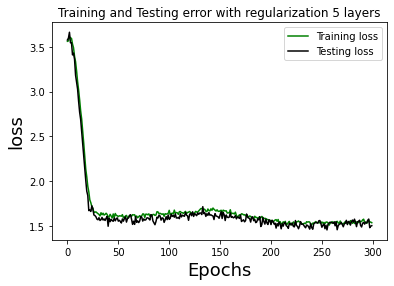

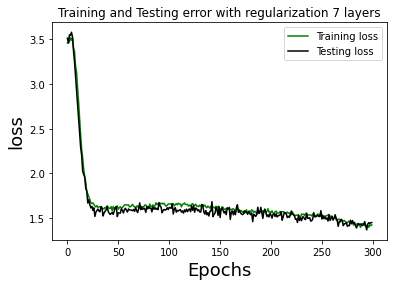

In [294]:
plot.title('Training and Testing error with regularization 5 layers')
plot.plot(range(300), train_errors_reg_5, 'green', label='Training loss')
plot.plot(range(300), test_error_reg_5, 'black', label='Testing loss')
plot.xlabel('Epochs',size=18)
plot.ylabel('loss',size=18)
plot.legend()
plot.show()
plot.title('Training and Testing error with regularization 7 layers')
plot.plot(range(300), train_errors_reg_7, 'green', label='Training loss')
plot.plot(range(300), test_error_reg_7, 'black', label='Testing loss')
plot.xlabel('Epochs',size=18)
plot.ylabel('loss',size=18)
plot.legend()
plot.show()

## Checking predicted ascii value and label

In [182]:

print(final_predicted_values[1])
print(ytest[1])
print(int("".join(str(x) for x in ytest[1]), 2) - 48)

[1.00000000e+00 1.00000000e+00 1.96396253e-04 8.81004227e-01
 9.99999983e-01 4.48151563e-05]
[1 1 0 0 1 0]
2


# For 3,5,7 layers without regularization

In [279]:
def mlp_model(XTrain,YTrain,Xtest,Ytest,layers,learning_rate=0.00005,iterations = 300):
    
    train_errors = []
    test_errors = []
    final_predicted_values=[]
    parameters = get_layer_parameters(784,layers,128)
    for i in range(iterations):
        active_layers = forward_propogation(XTrain,parameters)
        active_layers,drop_outputs = forward_propogation_with_dropout(XTrain,parameters,0.0)
        train_errors.append(np.sum(np.abs(YTrain - active_layers[-1]))/XTrain.shape[0])
        print("Train error " + str(np.sum(np.abs(YTrain - active_layers[-1]))/XTrain.shape[0]))
        parameters = back_propagate(XTrain,YTrain,parameters,learning_rate,active_layers)
#         parameters = back_propagate_with_dropout(XTrain,YTrain,parameters,learning_rate,active_layers,drop_outputs,0.0)
        
#         parameters = back_propagate_with_regularization(XTrain,YTrain,parameters,learning_rate,active_layers,6.5)
        
#         test_active_layers,test_drop_outputs = forward_propogation_with_dropout(Xtest,parameters,0.0)
        test_active_layers = forward_propogation(Xtest,parameters)
        test_errors.append(np.sum(np.abs(Ytest - test_active_layers[-1]))/Xtest.shape[0])
        print("Test error " + str(np.sum(np.abs(Ytest - test_active_layers[-1]))/Xtest.shape[0]))
        final_predicted_values = test_active_layers[-1]
    return train_errors,test_errors,final_predicted_values
    

In [251]:
train_errors_3,test_error_3,final_predicted_values_3=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],3)
train_errors_5,test_error_5,final_predicted_values_5=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],5)
train_errors_7,test_error_7,final_predicted_values_7=mlp_model(Xtrain[:2000],Ytrain[:2000],xtest[:400],ytest[:400],7)

(128, 784)
(128, 128)
(128, 128)
(6, 128)
Train error 3.311847356693118
Test error 3.424650948121065
Train error 3.3268657809860125
Test error 3.351056167548533
Train error 3.2854901788647104
Test error 3.2464626473864677
Train error 3.235003336293992
Test error 3.120612472378612
Train error 3.1696128985390386
Test error 2.9819808364242077
Train error 3.098698789034407
Test error 2.84154009243183
Train error 3.02862394950891
Test error 2.707671874580111
Train error 2.9351320440127564
Test error 2.590462323142784
Train error 2.8169482564384625
Test error 2.4952611714627015
Train error 2.7701704174287753
Test error 2.418547574421441
Train error 2.623098553212314
Test error 2.3548810525327024
Train error 2.5370832858366232
Test error 2.299005115972844
Train error 2.4825050341021515
Test error 2.2449751854513504
Train error 2.393269845251559
Test error 2.1854002999328785
Train error 2.3122764212313456
Test error 2.115710915647193
Train error 2.246340054946761
Test error 2.0345346299671268


Train error 1.444878517942339
Test error 1.167332667783731
Train error 1.4271380769364845
Test error 1.165341537163917
Train error 1.4246370627003737
Test error 1.16333321509686
Train error 1.4365564611871142
Test error 1.1612008423375138
Train error 1.419000352332672
Test error 1.1590849693516736
Train error 1.4315788935947458
Test error 1.1569579436597432
Train error 1.4457303978216942
Test error 1.154835360008733
Train error 1.4208472701111072
Test error 1.1526954353086993
Train error 1.4259323074859909
Test error 1.1506461135317927
Train error 1.42029498504374
Test error 1.1487150794228338
Train error 1.4373278326969263
Test error 1.1468007817240808
Train error 1.4278304471938612
Test error 1.1450093765779024
Train error 1.4413479857147675
Test error 1.1433304616998392
Train error 1.4078536207581878
Test error 1.141632410883785
Train error 1.3959651706100797
Test error 1.1400112829995424
Train error 1.388074105052302
Test error 1.1383005044978896
Train error 1.3987565845230439
Test

Test error 0.9896664268221116
Train error 1.2321782329684923
Test error 0.9884898681882142
Train error 1.2507761598997673
Test error 0.9873619005682542
Train error 1.234888595658525
Test error 0.9862052656281753
Train error 1.2517242775014916
Test error 0.9850910274991768
Train error 1.2241614974543584
Test error 0.9840385122112087
Train error 1.2537475690770146
Test error 0.9829812535220327
Train error 1.2569979105687328
Test error 0.9820243725930723
Train error 1.2401279157957796
Test error 0.9810686198498877
Train error 1.2379269951783647
Test error 0.9802247542117728
Train error 1.2501776684403054
Test error 0.9794899899172157
Train error 1.1981228740209344
Test error 0.9787423632746135
Train error 1.226078508524106
Test error 0.9778863542616256
Train error 1.229115596370551
Test error 0.97695318556101
Train error 1.2201739956428592
Test error 0.9759721950102478
Train error 1.2120518313011392
Test error 0.9750297869289147
Train error 1.2181417597375757
Test error 0.9740128621725834

Train error 1.5891815150154067
Test error 1.4063492797957027
Train error 1.6032523556117468
Test error 1.4062927518495687
Train error 1.5697708116655384
Test error 1.4062033413746533
Train error 1.5808959921084402
Test error 1.4060665131355492
Train error 1.5573373021074695
Test error 1.4059396843152505
Train error 1.5907735654238973
Test error 1.4058695117023603
Train error 1.585242082170662
Test error 1.4057964770781302
Train error 1.583102659289026
Test error 1.405784451807807
Train error 1.5931749171457186
Test error 1.4057371250134056
Train error 1.5719123806615105
Test error 1.4056942605291944
Train error 1.620467941867803
Test error 1.4056576011273818
Train error 1.5950410910942192
Test error 1.4055403051575361
Train error 1.5801435740484149
Test error 1.4053670830003804
Train error 1.5881872876805063
Test error 1.4051570749190676
Train error 1.5718341995338552
Test error 1.4049702246150133
Train error 1.5862252615171972
Test error 1.4048058774722623
Train error 1.59278646990046

Train error 1.5841174032273193
Test error 1.3786710129597401
Train error 1.5750334964610584
Test error 1.378599422793
Train error 1.5643206417681468
Test error 1.3786948223601012
Train error 1.5726708926447635
Test error 1.3787781785430127
Train error 1.575969710208764
Test error 1.378988594042367
Train error 1.5930831533190697
Test error 1.379283579651492
Train error 1.6118205627192446
Test error 1.3794902816532124
Train error 1.5705534805938264
Test error 1.3797877680936972
Train error 1.5594512738467223
Test error 1.380102550883663
Train error 1.5723831349760085
Test error 1.3802114644271586
Train error 1.552163026430193
Test error 1.3801262168237358
Train error 1.5801181814331504
Test error 1.3800351922898768
Train error 1.563558822308679
Test error 1.3799831965026335
Train error 1.5549527905325036
Test error 1.3800214417483088
Train error 1.5880835029664202
Test error 1.3801039730272595
Train error 1.5687454356204904
Test error 1.3801381348871231
Train error 1.5757153413703888
Tes

Train error 1.6141558298005245
Test error 1.4685911194939434
Train error 1.6132703672443383
Test error 1.4707473293913358
Train error 1.5988119847388327
Test error 1.473040954265942
Train error 1.6323639240484376
Test error 1.4750882699016317
Train error 1.5971265863321837
Test error 1.4775559237636051
Train error 1.5982490058184615
Test error 1.4798271357085695
Train error 1.586353687892709
Test error 1.4815300653518937
Train error 1.6106807485426198
Test error 1.4826492099242587
Train error 1.5988740387219755
Test error 1.4838084512149194
Train error 1.6022428760685257
Test error 1.4850890329193986
Train error 1.595776661364647
Test error 1.4857941813339426
Train error 1.595646169515327
Test error 1.486529006069606
Train error 1.602292457407942
Test error 1.4869528553659197
Train error 1.5956237345250168
Test error 1.4878382848769838
Train error 1.5842186670529719
Test error 1.4887981010768636
Train error 1.5992001918760588
Test error 1.490734293824816
Train error 1.6061769727145483


Train error 1.6241755100363588
Test error 1.5414334057282684
Train error 1.6129219408063327
Test error 1.5404138480465996
Train error 1.6222939107602175
Test error 1.5404886491992846
Train error 1.6200912865415216
Test error 1.5403643022004727
Train error 1.614666385610741
Test error 1.540466379789726
Train error 1.6220779843993272
Test error 1.541026570686726
Train error 1.6274397093625124
Test error 1.5413609685161618
Train error 1.623137379364927
Test error 1.5418328158847772
Train error 1.6076849089589054
Test error 1.5427127836761252
Train error 1.6217584549414346
Test error 1.5434343241629227
Train error 1.6270768405919906
Test error 1.5439390582374017
Train error 1.6207972266832482
Test error 1.544755550109383
Train error 1.6097595869664152
Test error 1.5454647259519623
Train error 1.6093400525405264
Test error 1.5459411242140617
Train error 1.6243917265073253
Test error 1.5463928499595279
Train error 1.638928153003242
Test error 1.5461433459660958
Train error 1.627315130309291


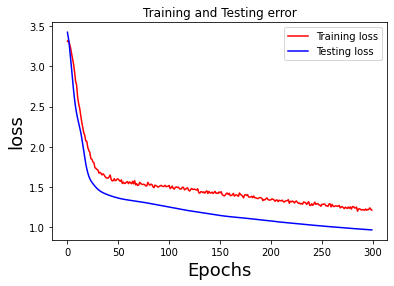

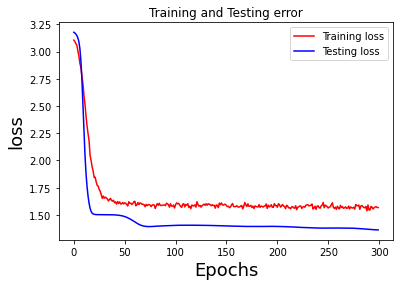

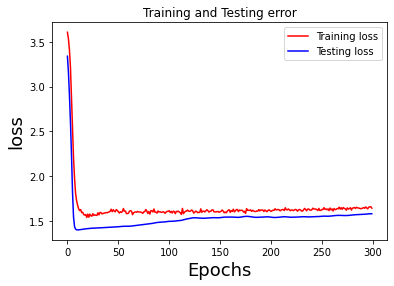

In [252]:
plot.title('Training and Testing error')
plot.plot(range(300), train_errors_3, 'red', label='Training loss')
plot.plot(range(300), test_error_3, 'blue', label='Testing loss')
plot.xlabel('Epochs',size=18)
plot.ylabel('loss',size=18)
plot.legend()
plot.show()
plot.title('Training and Testing error')
plot.plot(range(300), train_errors_5, 'red', label='Training loss')
plot.plot(range(300), test_error_5, 'blue', label='Testing loss')
plot.xlabel('Epochs',size=18)
plot.ylabel('loss',size=18)
plot.legend()
plot.show()
plot.title('Training and Testing error')
plot.plot(range(300), train_errors_7, 'red', label='Training loss')
plot.plot(range(300), test_error_7, 'blue', label='Testing loss')
plot.xlabel('Epochs',size=18)
plot.ylabel('loss',size=18)
plot.legend()
plot.show()

# Mean square error between y predicted and actual

In [253]:
#Without regularization
from sklearn.metrics import mean_squared_error,accuracy_score,f1_score
print(mean_squared_error(ytest[:400],final_predicted_values_3))
print(mean_squared_error(ytest[:400],final_predicted_values_5))
print(mean_squared_error(ytest[:400],final_predicted_values_7))


0.12826176447169343
0.20489141196336258
0.15322550612904517


# With noise in test images

## Gaussian Noise

(10000, 28, 28, 1)


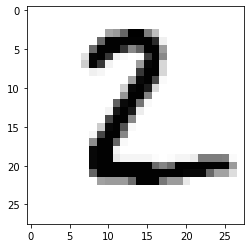

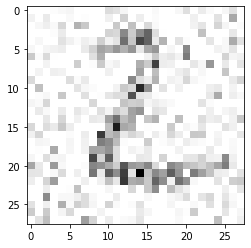

In [290]:
noise_x = add_noise(xtest,0,math.sqrt(0.2),noise_type='gaussian')
k =xtest[1].reshape(28,28)
img = xtest[1].reshape((28,28))
plot.imshow(img, cmap="Greys")
plot.show()

k =noise_x[1].reshape(28,28)
img = noise_x[1].reshape((28,28))
plot.imshow(img, cmap="Greys")
plot.show()


## Speckle Noise

(10000, 28, 28, 1)
a


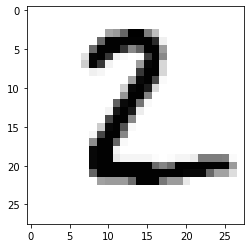

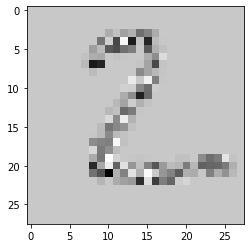

In [291]:
noise_speckle_x = add_noise(xtest,0,math.sqrt(0.2),noise_type='speckle')
k =xtest[1].reshape(28,28)
img = xtest[1].reshape((28,28))
plot.imshow(img, cmap="Greys")
plot.show()

k =noise_speckle_x[1].reshape(28,28)
img = noise_speckle_x[1].reshape((28,28))
plot.imshow(img, cmap="Greys")
plot.show()


In [292]:

train_errors_noise_5,test_error_5,final_predicted_values_noise_5=mlp_model(Xtrain[:2000],Ytrain[:2000],noise_x[:400],ytest[:400],5)

train_errors_sknoise_5,test_error_sk5,final_predicted_values_sknoise_5=mlp_model(Xtrain[:2000],Ytrain[:2000],noise_speckle_x[:400],ytest[:400],5)



(128, 784)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(6, 128)
Train error 3.409010010450257
Test error 3.3542191409131896
Train error 3.3475159840471354
Test error 3.3339567534943537
Train error 3.3286793638629537
Test error 3.3140671784903177
Train error 3.2916972444860093
Test error 3.298080249127238
Train error 3.281722256351057
Test error 3.2853265341481346
Train error 3.2309954539706993
Test error 3.273851334457666
Train error 3.1612055510535257
Test error 3.2611871051231494
Train error 3.107427190839187
Test error 3.243369711018321
Train error 3.053717069617128
Test error 3.2121286929512562
Train error 3.0136255440991597
Test error 3.145692596761791
Train error 2.961987221683478
Test error 3.004121753094438
Train error 2.8930065901517317
Test error 2.786940089094736
Train error 2.818233527024357
Test error 2.6011182251289697
Train error 2.7474073167681863
Test error 2.504827993806141
Train error 2.6785081733256786
Test error 2.4594569357799965
Train error 2.6141498710044955
Tes

Train error 1.5910915486077526
Test error 1.437657888569355
Train error 1.6085185367369141
Test error 1.437482662451588
Train error 1.5885621411369366
Test error 1.4372446998681727
Train error 1.5743673882076272
Test error 1.4370631096835538
Train error 1.5868359547242412
Test error 1.436956798482727
Train error 1.5740417051682865
Test error 1.4368711787049444
Train error 1.6057934695609288
Test error 1.4367746910381385
Train error 1.5766544809250744
Test error 1.436640096691308
Train error 1.578633835952226
Test error 1.4366048401001603
Train error 1.5883610411096396
Test error 1.4366011546694937
Train error 1.5850907769851292
Test error 1.4366228632390101
Train error 1.5937327122430827
Test error 1.4365962882165673
Train error 1.591745998850667
Test error 1.4365562614882947
Train error 1.5776427230283325
Test error 1.4364769111469946
Train error 1.5684527820773888
Test error 1.43641897923405
Train error 1.5836129549104117
Test error 1.4363993897242933
Train error 1.5815733470775133
T

Train error 1.5811110103816517
Test error 1.4690280685717383
Train error 1.5887050049947185
Test error 1.4690504546636796
Train error 1.5504333228788851
Test error 1.469192586633048
Train error 1.568349602642527
Test error 1.469272264040824
Train error 1.5643474572725808
Test error 1.469466626019111
Train error 1.5682418557332254
Test error 1.4700653828726369
Train error 1.5603950502151442
Test error 1.4705948035137448
Train error 1.5728664141966406
Test error 1.47116838099721
Train error 1.5740981014494453
Test error 1.4716821883692648
Train error 1.5646007762160705
Test error 1.4721701785368801
Train error 1.5576266978194162
Test error 1.4727729002354002
Train error 1.5676960778549087
Test error 1.4735557602807745
Train error 1.5578861908067199
Test error 1.4742133198901946
Train error 1.5674447812211643
Test error 1.4746218018523942
Train error 1.5850757745022237
Test error 1.4750510371844552
Train error 1.5631801740309057
Test error 1.4755049496980206
Train error 1.562214006111265


Test error 1.4984780504117987
Train error 1.5854591295905331
Test error 1.4984279658292443
Train error 1.6076915668809169
Test error 1.4983196278154205
Train error 1.5774521236891719
Test error 1.498109474647609
Train error 1.591442676772982
Test error 1.4978772578398798
Train error 1.5879953512214016
Test error 1.497883831778051
Train error 1.5915603417017883
Test error 1.4978989270343375
Train error 1.598844829019606
Test error 1.4980701748304635
Train error 1.5829631748179263
Test error 1.498263512307657
Train error 1.5880321667185826
Test error 1.498412405708246
Train error 1.6019825015491365
Test error 1.4985874134818955
Train error 1.6329930721975825
Test error 1.4986180824947173
Train error 1.5837804674940978
Test error 1.498657011858127
Train error 1.623132722296763
Test error 1.4985523924028923
Train error 1.5945799056756302
Test error 1.4984122301532556
Train error 1.5931937931317106
Test error 1.4981708155469857
Train error 1.6067335765742214
Test error 1.497961584885765
Tra

Train error 1.5532549911241946
Test error 1.505779720482642
Train error 1.5786628650452905
Test error 1.5065128153300649
Train error 1.6052845654309849
Test error 1.5070373154839138
Train error 1.5826357794728454
Test error 1.5075488569421853
Train error 1.574468585104291
Test error 1.507926734912187
Train error 1.576083525020509
Test error 1.5085867146027485
Train error 1.5932008453450017
Test error 1.5091207435646459
Train error 1.5922814339227958
Test error 1.5098453534193874
Train error 1.5678587873518057
Test error 1.5104408561996292
Train error 1.5461520206810762
Test error 1.5111054531254269
Train error 1.5908427848182296
Test error 1.5117570339582869
Train error 1.5815228619512722
Test error 1.5125593743967694
Train error 1.5840147099393331
Test error 1.5132570799462706
Train error 1.5908956109493806
Test error 1.5140592222207794
Train error 1.5798445919485484
Test error 1.5152866877950715
Train error 1.5689761623003209
Test error 1.5162854968916997
Train error 1.58136567797139

# Mean square error between y predicted and actual

In [293]:
from sklearn.metrics import mean_squared_error,accuracy_score,f1_score
print(mean_squared_error(ytest[:400],final_predicted_values_noise_5))
print(mean_squared_error(ytest[:400],final_predicted_values_sknoise_5))

0.20265113687637473
0.17476684009353802
